In [34]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

## Step 1: Load dataset

In [58]:
data_dir = "/home/sda1/yanxh/data/Seurat_demo_data/bm_cite/"
out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/bm-cite'

In [36]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_mat_count.mtx')).T)
adt_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'adt_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'adt_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data['batch'] = meta_data.donor.to_numpy()

rna_count_mat.shape, adt_count_mat.shape

Reading `mtx` files...


((30672, 17009), (30672, 25))

In [37]:
train_idx = np.where((meta_data.batch=='batch1').to_numpy())[0]
test_idx  = np.where((meta_data.batch=='batch2').to_numpy())[0]

train_idx.size, test_idx.size

(14468, 16204)

## down scale data

In [38]:
ad_mult_rna = sc.AnnData(rna_count_mat[train_idx])
ad_mult_rna.var_names = rna_names
sc.pp.highly_variable_genes(ad_mult_rna, flavor='seurat_v3', n_top_genes=5000)
hvg_idx = np.where(ad_mult_rna.var.highly_variable)[0]
hvg_names = rna_names[hvg_idx]

### format data

In [39]:
n_batches = 3

genes = hvg_names
proteins = adt_names
feats_name = {"rna": genes, "adt": proteins}

barcodes = [cell_names[train_idx], cell_names[test_idx], cell_names[test_idx]]
labels = [meta_data.loc[_, 'celltype.l2'].to_list() for _ in barcodes]
mods = [['multiome']*train_idx.size, ['rna']*test_idx.size, ['atac']*test_idx.size]  # mod_lisi=batch_lisi
batches = [['batch1']*train_idx.size, ['batch2']*test_idx.size, ['batch2']*test_idx.size]  # for convenience of eval_bridge

In [40]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batch 1
counts_rna1 = rna_count_mat[train_idx][:, hvg_idx]
counts_rna1 = scmomat.preprocess(counts_rna1.A, modality = "RNA", log = False)
counts_rna2 = rna_count_mat[test_idx][:, hvg_idx]
counts_rna2 = scmomat.preprocess(counts_rna2.A, modality = "RNA", log = False)
counts_rnas = [counts_rna1, counts_rna2, None]

# scATAC-seq of batch 1
counts_adt1 = adt_count_mat[train_idx]
counts_adt1 = scmomat.preprocess(counts_adt1.A, modality = "ADT", log = True)
counts_adt3 = adt_count_mat[test_idx]
counts_adt3 = scmomat.preprocess(counts_adt3.A, modality = "ADT", log = True)
counts_adts = [counts_adt1, None, counts_adt3]

In [41]:
# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "adt": counts_adts}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 37.9184
	 loss reconstruction: 0.03756
	 loss regularization: 0.36000
Epoch 1000, Validating Loss: 16.3785
	 loss reconstruction: 0.01580
	 loss regularization: 0.57450
Epoch 2000, Validating Loss: 19.0855
	 loss reconstruction: 0.01864
	 loss regularization: 0.44625
running time: 61.174590826034546


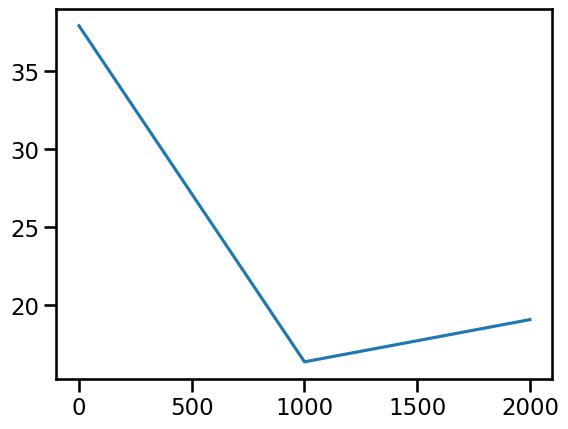

In [42]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
lamb = 0.001 
T = 2000     # 4000 cause overfit
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

/home/yanxh/gitrepo/multi-omics-matching/scMoMaT/scmomat/utils.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(_kwargs["colormap"], len(unique_cluster))


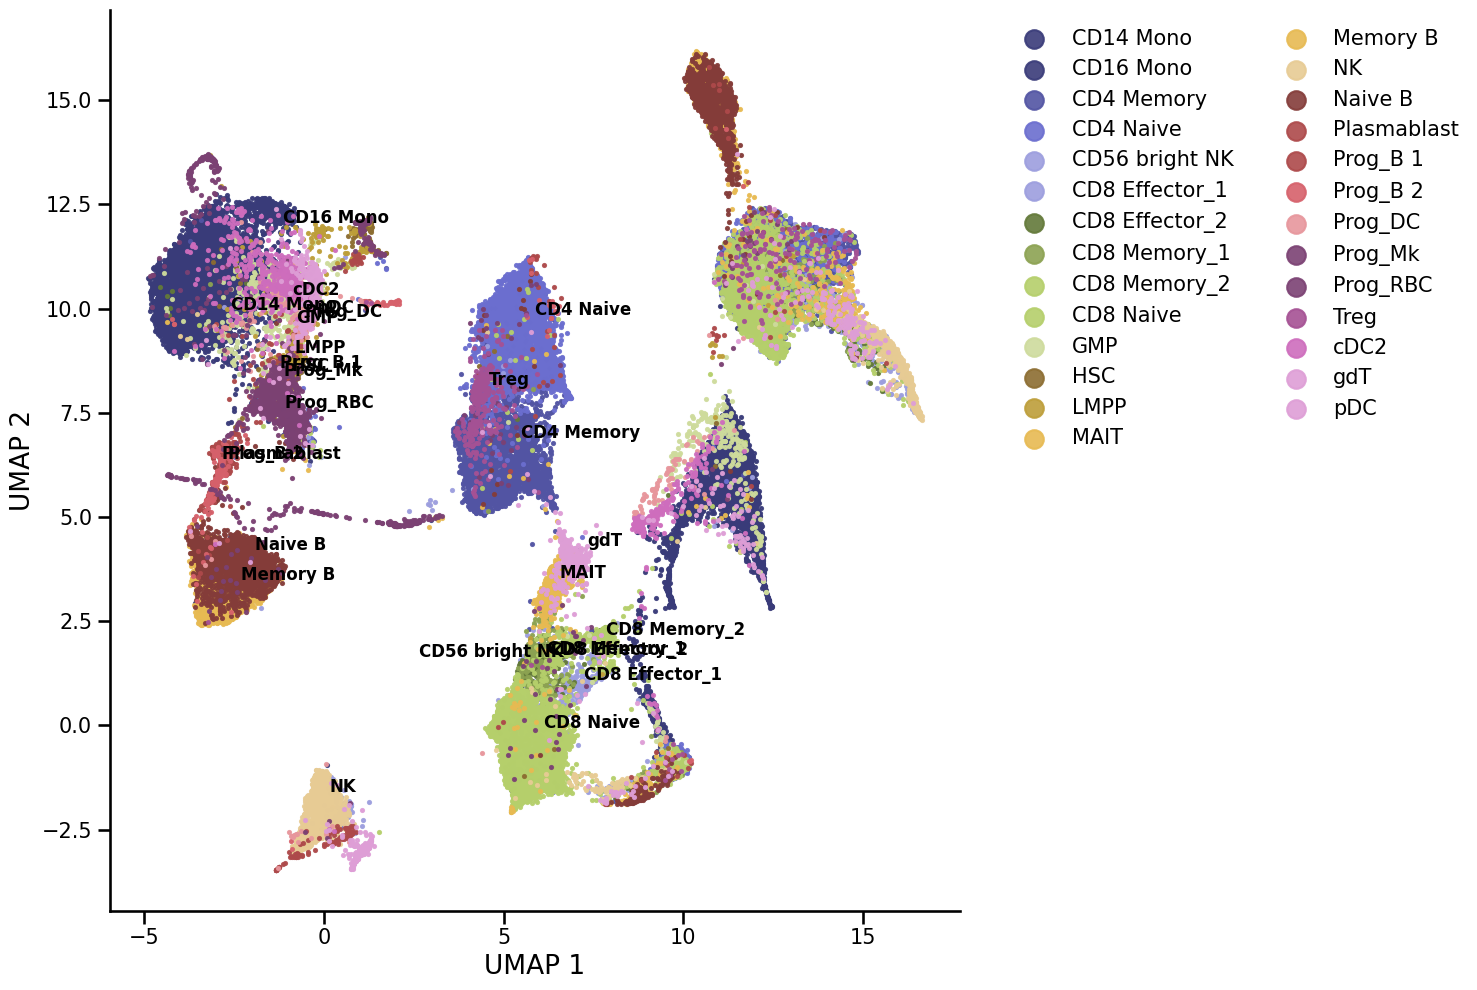

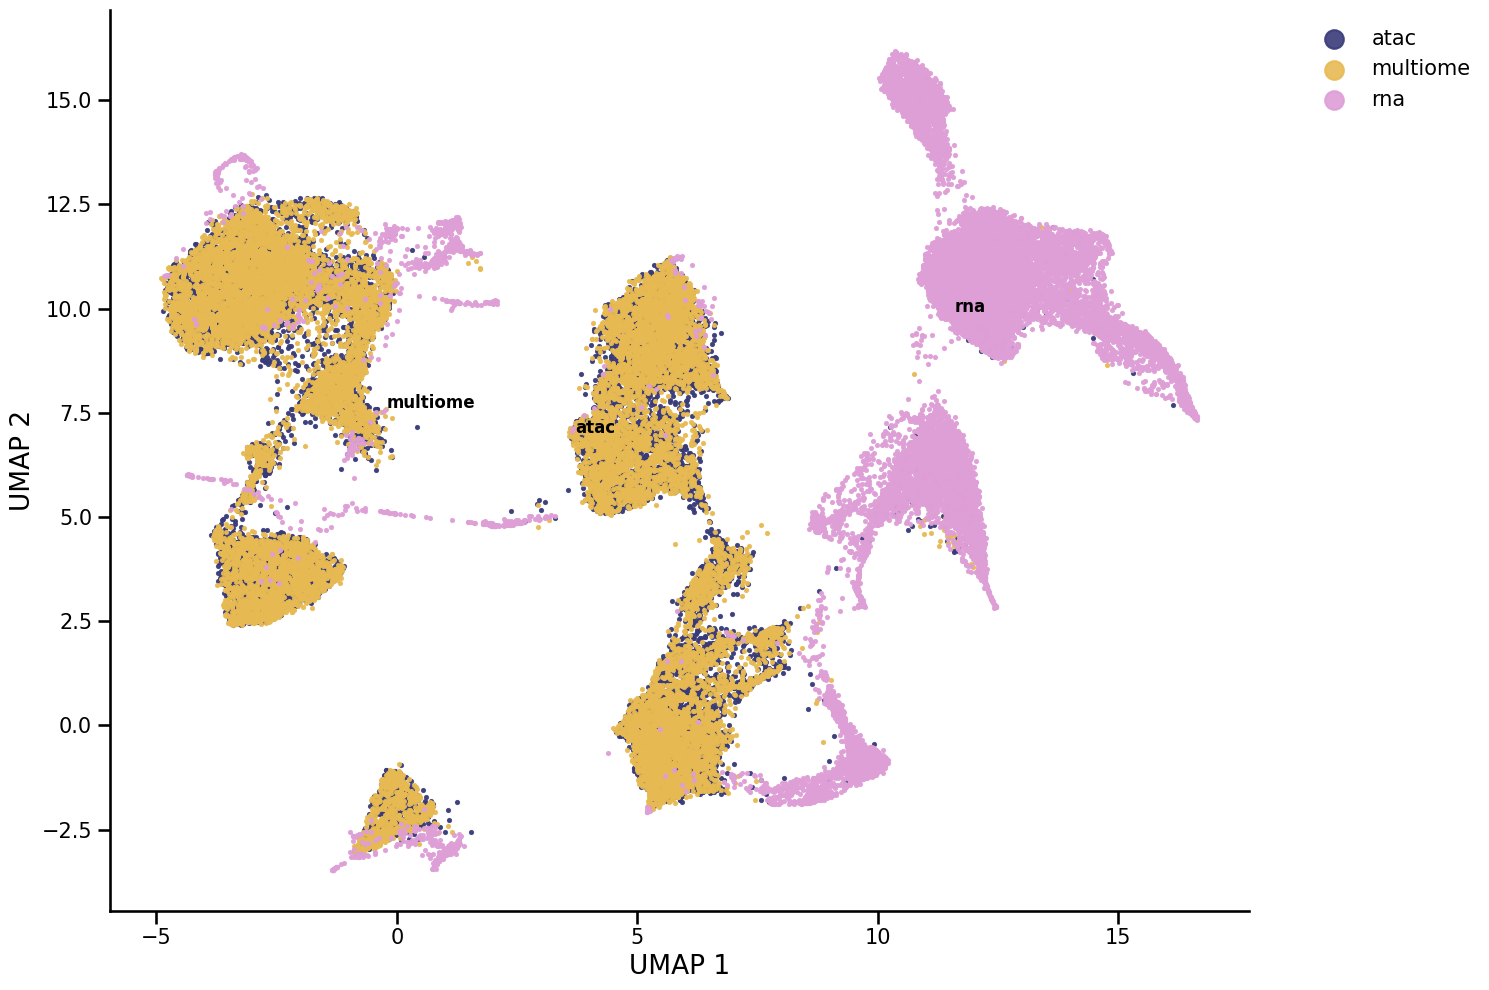

In [43]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

In [44]:
zs = model.extract_cell_factors()

# n_neighbors = 100
# r = None
# resolution = 0.9
# knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# # labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
# x_umap = scmomat.calc_umap_embedding(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(mods),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(labels),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# Eval results

In [45]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)
ad_mosaic.obs['mod-batch'] = ad_mosaic.obs['mod'] + '-' + ad_mosaic.obs['batch']

# ad_mosaic.obsm['X_umap'] = x_umap

# ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
# )
# ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [46]:
import sys
sys.path.insert(0, '.')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

## before harmony

In [60]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], use_lisi=True, use_rep='X_emb', use_neighbors=False)  # mod-lisi = batch_lisi

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/tempfile.py:818: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/lisi_ojgrsc6k'>
  _warnings.warn(warn_message, ResourceWarning)


cell_type_LISI=0.98134
mod_LISI=0.40845
GC=0.79153
NMI=0.60656
ARI=0.49754


In [20]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6065555218101962, 0.49754352595477247)

In [21]:
ad_gex_test = sc.AnnData(zs[1], obsm={"X_emb":zs[1]})
ad_adt_test = sc.AnnData(zs[2], obsm={"X_emb":zs[2]})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; 
ad_adt_test.obs['cell_type'] = labels[2]; ad_adt_test.obs['batch'] = batches[2]; 

r = eval_bridge(
    ad_gex_test, ad_adt_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb',
    use_acc=False
)

# foscttm=r['FOSCTTM']
# ms=r['Match_score']

FOSCTTM=0.41621
Match_score=0.00009


## after harmony

In [48]:
from preprocessing import harmony

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

# r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], use_lisi=True, use_rep='X_emb_harmony', use_neighbors=False) 

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [23]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.521981252436419, 0.3474002547169252)

In [63]:
z_har = ad_mosaic.obsm['X_emb_harmony']
z_har_b2 = z_har[len(zs[0]):(len(zs[0]) + len(zs[1]))]
z_har_b3 = z_har[-len(zs[2]):]
ad_gex_test = sc.AnnData(z_har_b2, obsm={"X_emb_harmony":z_har_b2})
ad_adt_test = sc.AnnData(z_har_b3, obsm={"X_emb_harmony":z_har_b3})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; 
ad_adt_test.obs['cell_type'] = labels[2]; ad_adt_test.obs['batch'] = batches[2]; 

r = eval_bridge(
    ad_gex_test, ad_adt_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb_harmony',
    use_acc=False
)

FOSCTTM=0.40036
Match_score=0.00006


In [64]:
r

{'FOSCTTM': 0.4003593469855248, 'Match_score': 5.673993578214758e-05}

# save plots

In [49]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [50]:
modD = {'atac':'other', 'multiome':'multiome', 'rna':'gex'}
ad_mosaic.obs['mod2'] = [modD[_] for _ in ad_mosaic.obs['mod']]
ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs['mod2'].astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

In [51]:
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='umap_be')
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='umap_af')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

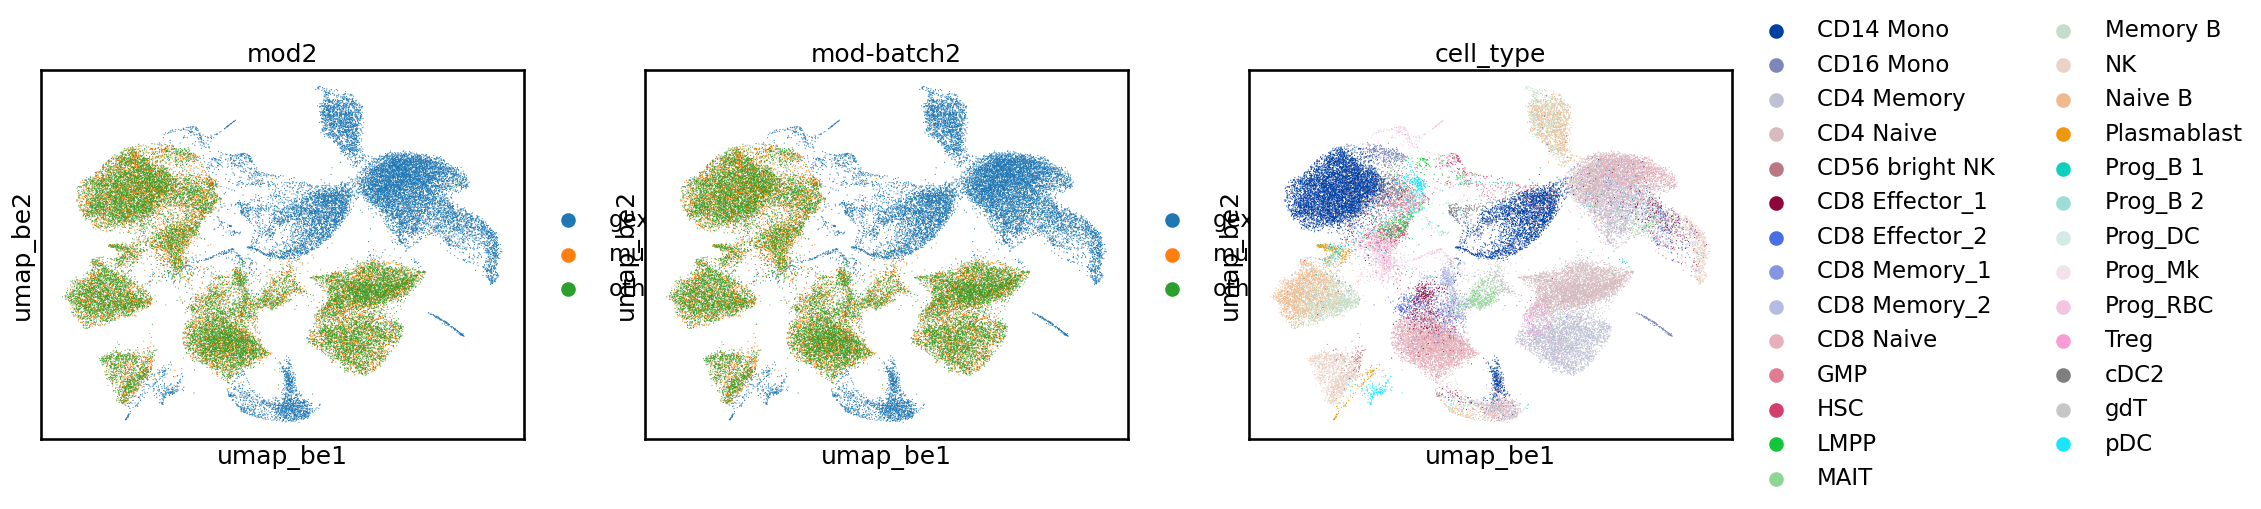

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

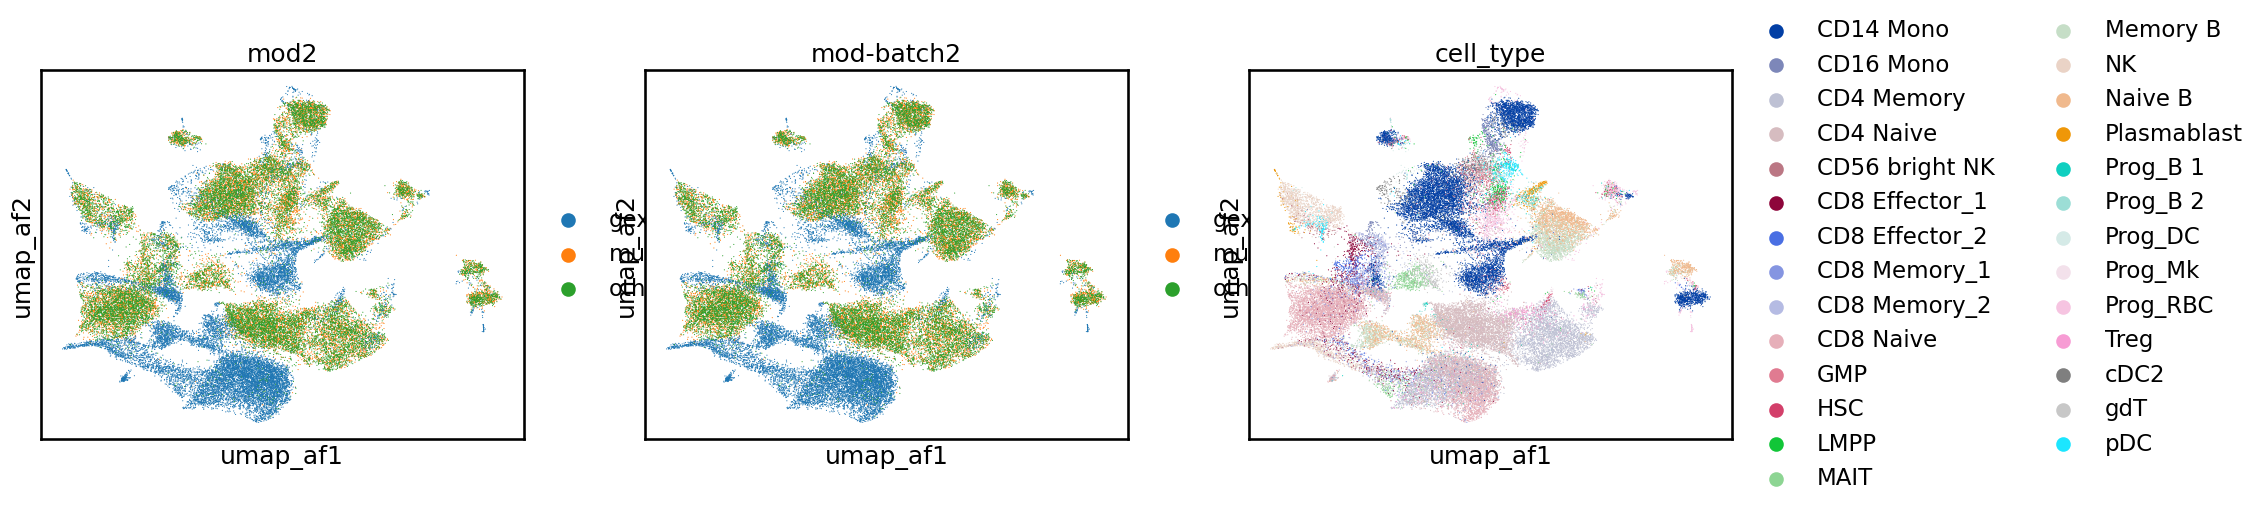

In [52]:
sc.pl.embedding(ad_mosaic, basis='umap_be', color=['mod2', 'mod-batch2', 'cell_type'])
sc.pl.embedding(ad_mosaic, basis='umap_af', color=['mod2', 'mod-batch2', 'cell_type'])

In [54]:
import json
with open('/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap/bm-cite_color_dict.json', 'r') as json_file:
    type_color_dict = json.load(json_file)
    
ad_mosaic.uns['cell_type_colors'] = [type_color_dict[_] for _ in ad_mosaic.obs.cell_type.cat.categories]

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


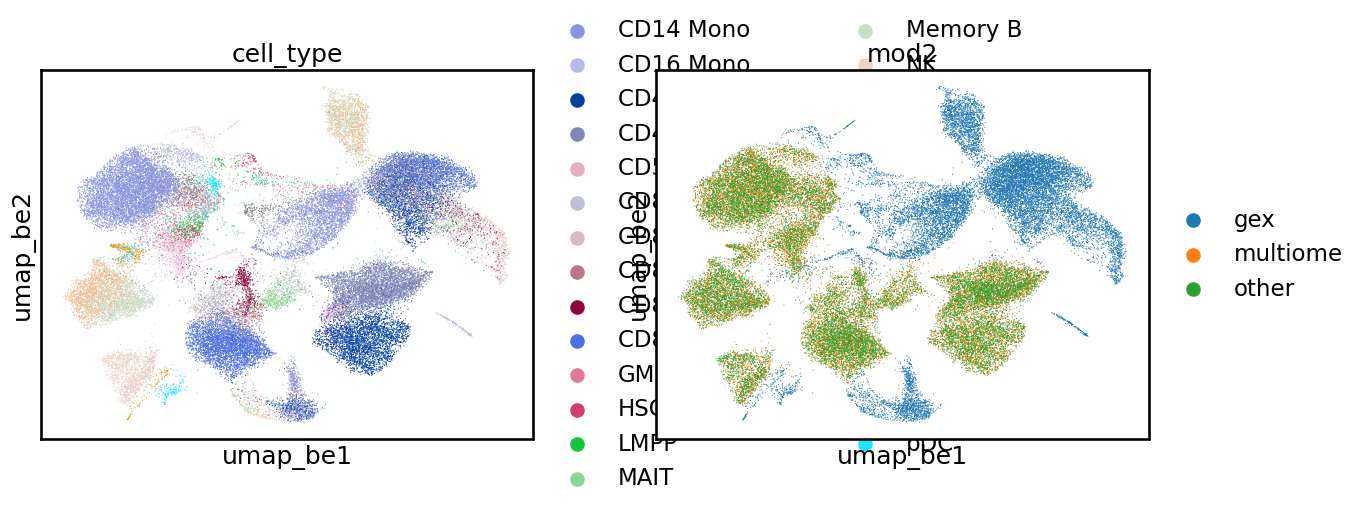

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


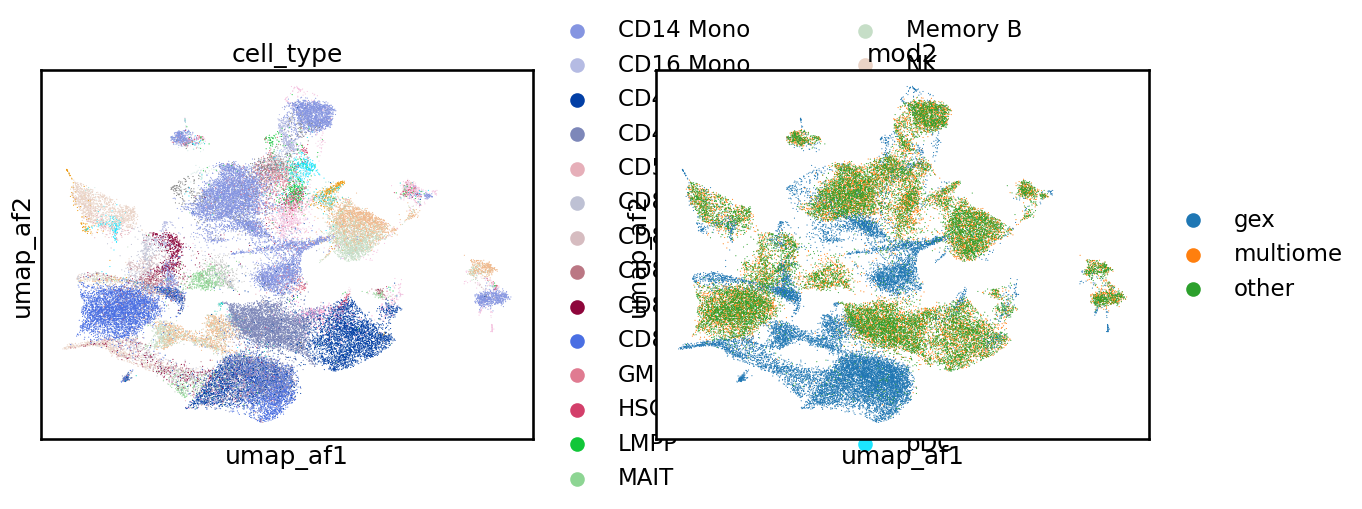

In [57]:
sc.pl.embedding(ad_mosaic, basis='umap_be', color=['cell_type', 'mod2'])
sc.pl.embedding(ad_mosaic, basis='umap_af', color=['cell_type', 'mod2'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

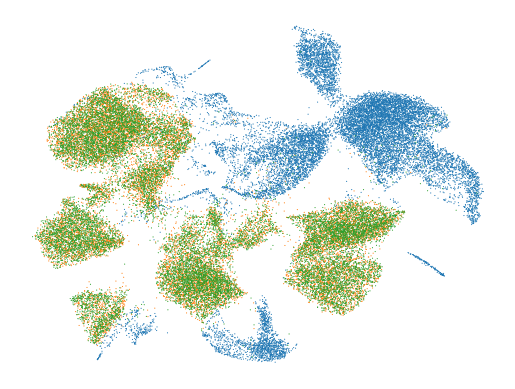

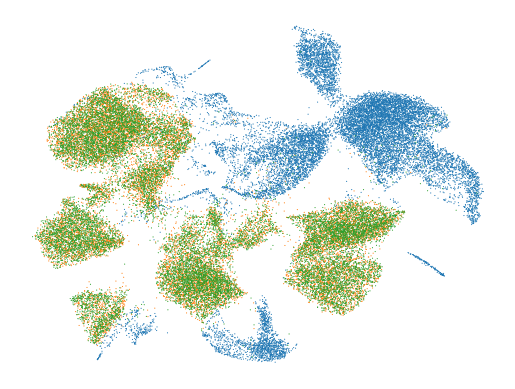

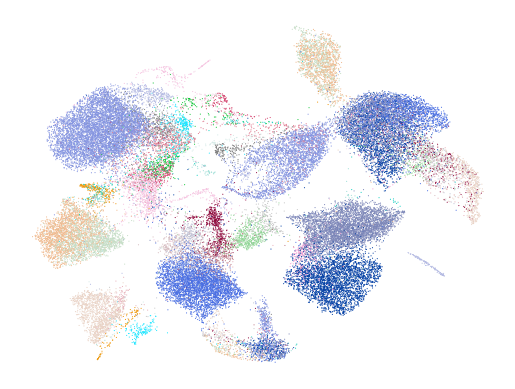

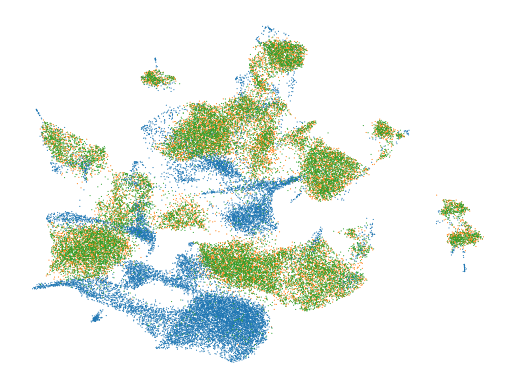

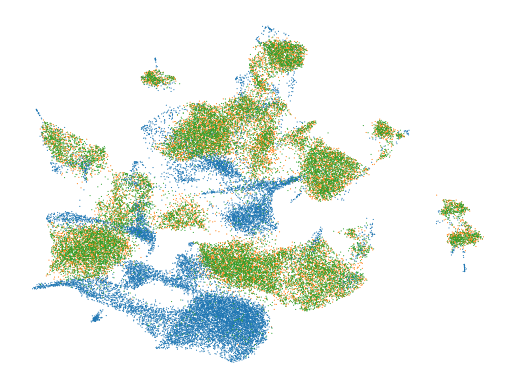

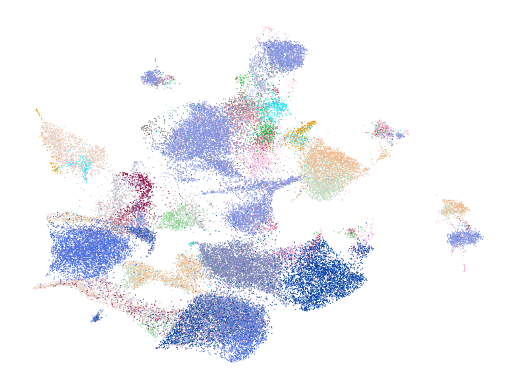

In [66]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

save_umap(ad_mosaic, 'umap_be', ['mod2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT_case1_bm-cite')
save_umap(ad_mosaic, 'umap_af', ['mod2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT-harmony_case1_bm-cite')

In [31]:
np.save(join(umap_save_dir, 'scMoMaT_case1_bm-cite_umap.npy'), ad_mosaic.obsm['umap_be'])
np.save(join(umap_save_dir, 'scMoMaT-harmony_case1_bm_umap.npy'), ad_mosaic.obsm['umap_af'])

In [32]:
1

1